In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/generative-dog-images/Annotation.zip
/kaggle/input/generative-dog-images/all-dogs.zip


In [2]:
from __future__ import print_function
import time
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.utils as vutils
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from PIL import Image


In [3]:
import zipfile



# Will unzip the files so that you can see them..
with zipfile.ZipFile("../input/generative-dog-images/all-dogs.zip","r") as z:
    z.extractall(".")


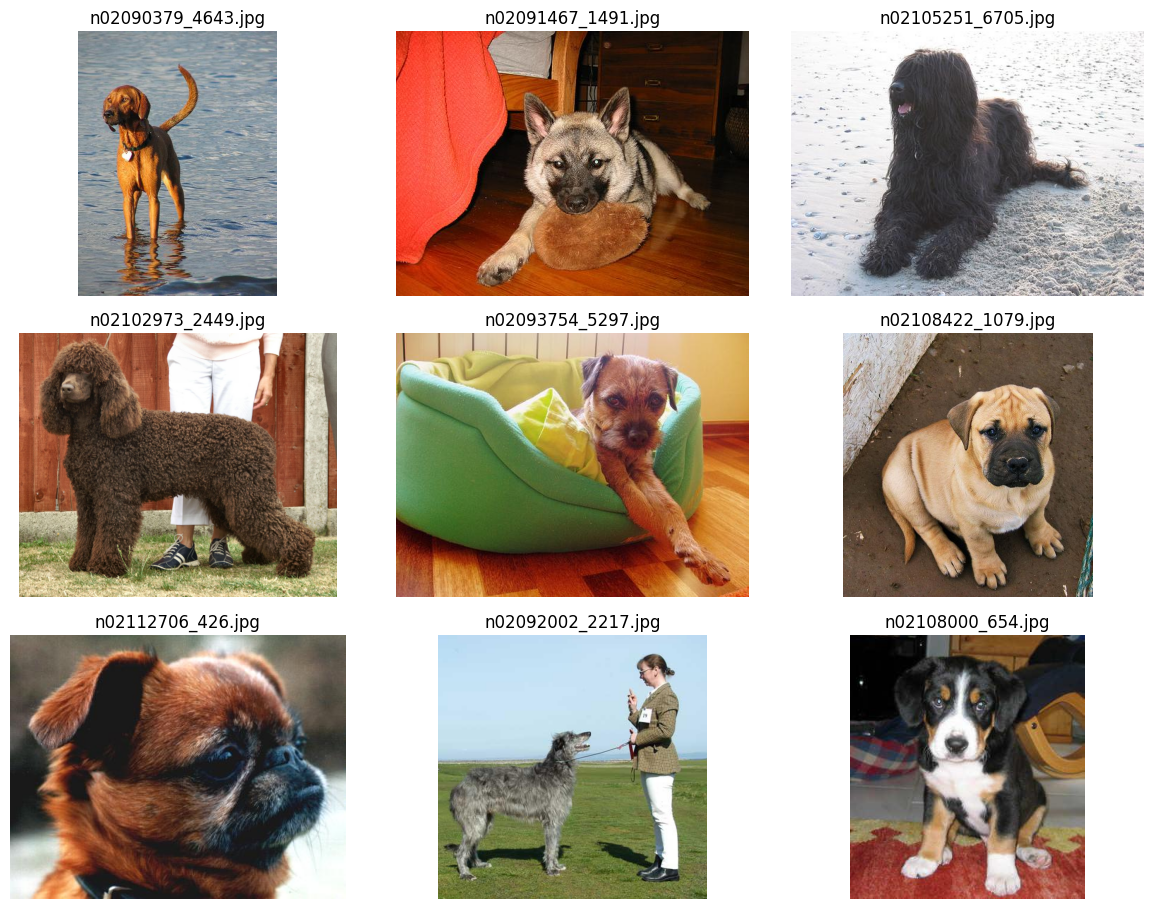

In [4]:
images = os.listdir('all-dogs/')
fig, axes = plt.subplots(3,3,figsize=(12,10))
for indx, axis in enumerate(axes.flatten()):
#     rnd_indx = np.random.randint(0, len(os.listdir(PATH)))
    img = plt.imread("all-dogs/"+images[indx])
    imgplot = axis.imshow(img)
    axis.set_title(images[indx])
    axis.set_axis_off()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])


In [5]:
class DogDataset(Dataset):
    def __init__(self, img_dir, transform1=None, transform2=None):
    
        self.img_dir = img_dir
        self.img_names = os.listdir(img_dir)
        self.transform1 = transform1
        self.transform2 = transform2
        
        self.imgs = []
        for img_name in self.img_names:
            img = Image.open(os.path.join(img_dir, img_name))
            
            if self.transform1 is not None:
                img = self.transform1(img)
                
            self.imgs.append(img)

    def __getitem__(self, index):
        img = self.imgs[index]
        
        if self.transform2 is not None:
            img = self.transform2(img)
        
        return img

    def __len__(self):
        return len(self.imgs)


In [6]:
batch = 32
img_size = 64
transform1 = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64)])

# Data augmentation and converting to tensors
random_transforms = [transforms.RandomRotation(degrees=5)]
transform2 = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.RandomApply(random_transforms, p=0.3), 
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                                 
train_dataset = DogDataset(img_dir='all-dogs/',
                           transform1=transform1,
                           transform2=transform2)


In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True,
                                           batch_size=batch, num_workers=4)
imgs = next(iter(train_loader))
imgs = imgs.numpy().transpose(0,2,3,1)


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


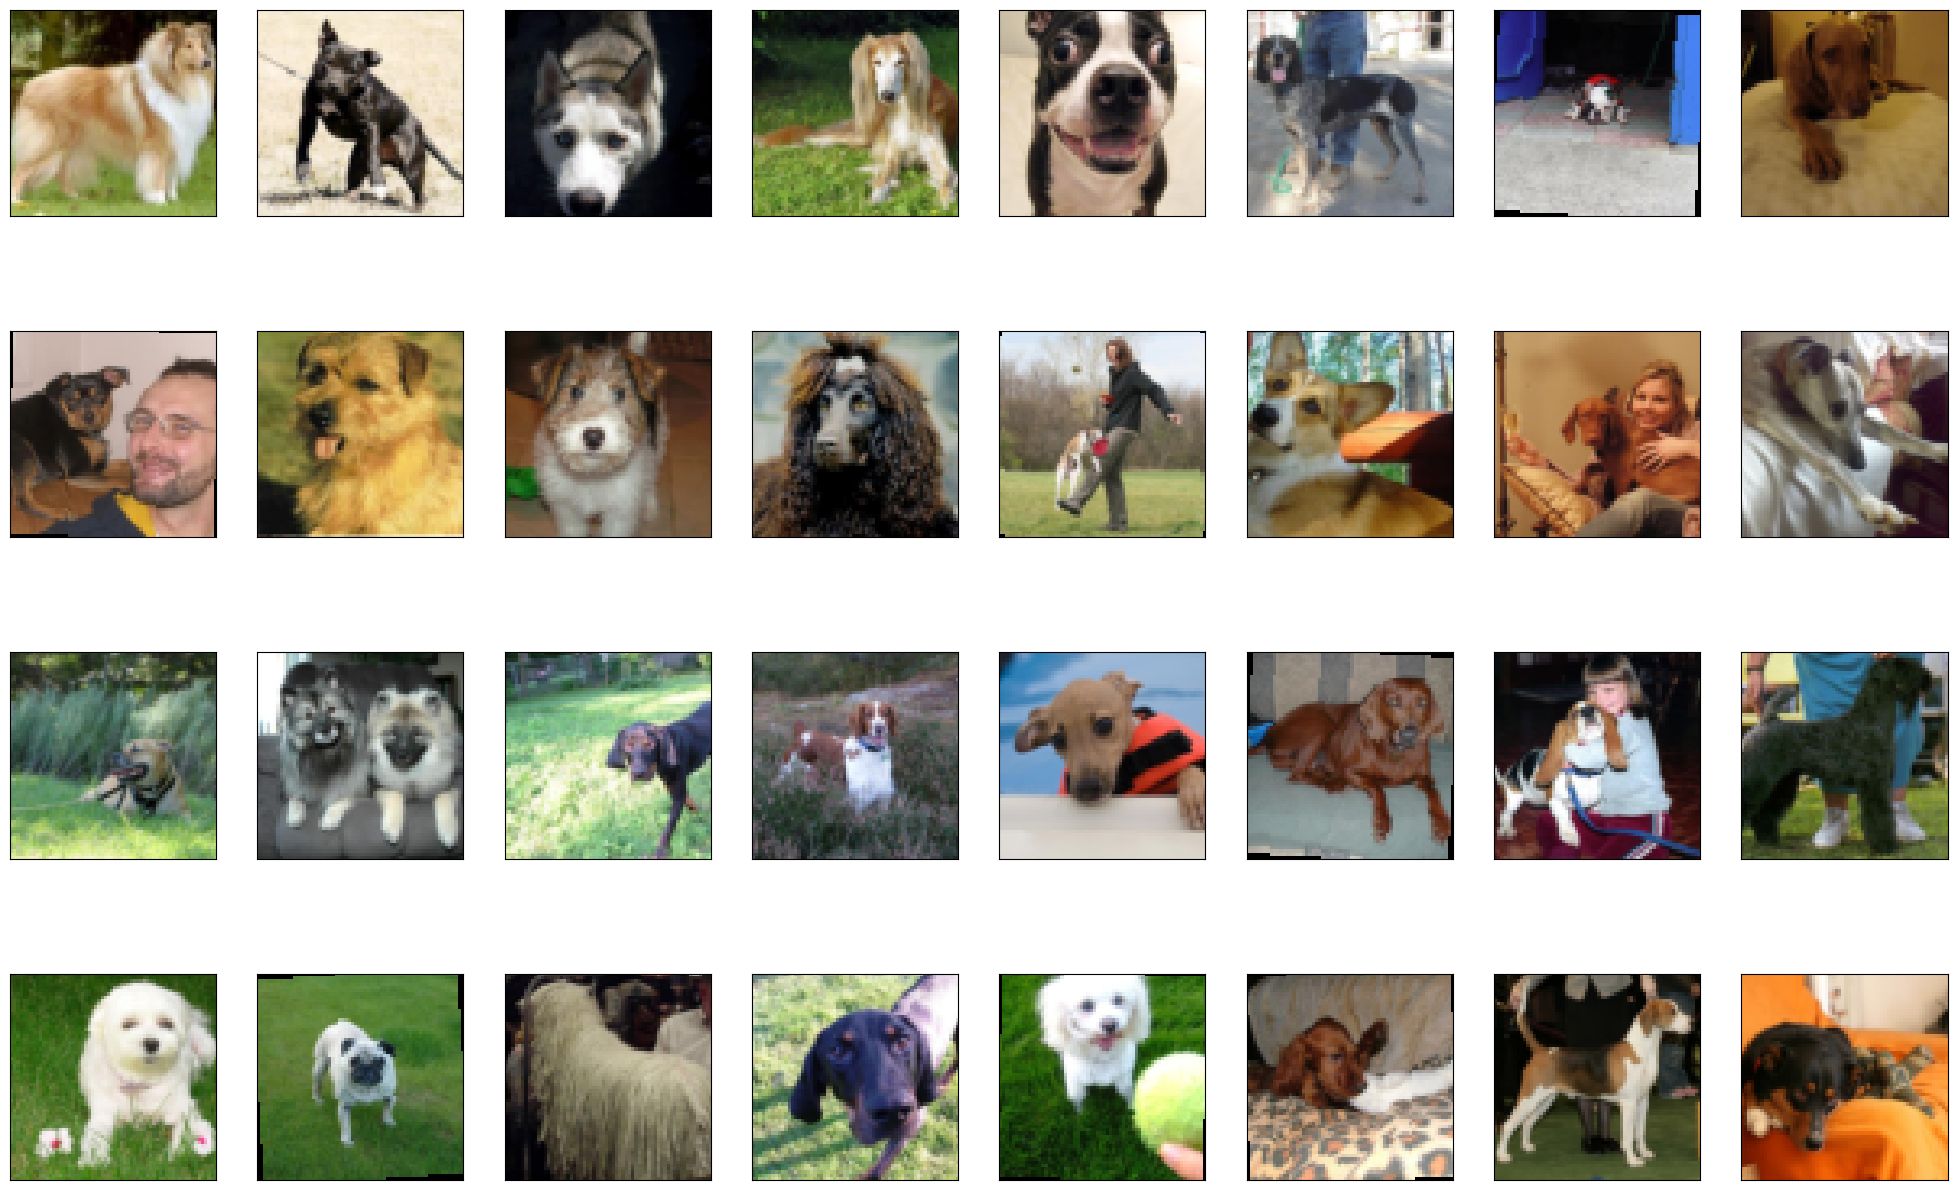

In [8]:
# Images after augmentation and all the changes
fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(imgs):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    
    plt.imshow((img+1)/2)


In [9]:
lr = 2e-4
beta1 = 0.5


# Note in standard gan, it would have been 1
real_label = 0.9
fake_label = 0
# size of the latent space
nz = 128


In [10]:
class Generator(nn.Module):
    def __init__(self,nz=128,channels=3):
        super(Generator,self).__init__()
        self.nz = nz
        self.channels = channels
        self.kernel = 4
        self.stride = 2
        self.padding = 1
        self.hidden0 = nn.Sequential(nn.ConvTranspose2d(self.nz,1024,kernel_size = self.kernel,stride = self.stride,padding=0,bias=False),
                                    nn.BatchNorm2d(1024),
                                    nn.LeakyReLU(0.2,inplace=True))
        self.hidden1 = nn.Sequential(nn.ConvTranspose2d(1024,512,kernel_size = self.kernel,stride = self.stride,padding=self.padding,bias=False),
                                    nn.BatchNorm2d(512),
                                    nn.LeakyReLU(0.2,inplace=True))
        self.hidden2 = nn.Sequential(nn.ConvTranspose2d(512,256,kernel_size = self.kernel,stride = self.stride,padding=self.padding,bias=False),
                                    nn.BatchNorm2d(256),
                                    nn.LeakyReLU(0.2,inplace=True),
                                    nn.Dropout(p=0.25))
        self.hidden3 = nn.Sequential(nn.ConvTranspose2d(256,128,kernel_size = self.kernel,stride = self.stride,padding=self.padding,bias=False),
                                    nn.BatchNorm2d(128),
                                    nn.LeakyReLU(0.2,inplace=True),
                                    nn.Dropout(0.25))
        self.hidden4 = nn.Sequential(nn.ConvTranspose2d(128,64,kernel_size = self.kernel,stride = self.stride,padding=self.padding,bias=False),
                                    nn.BatchNorm2d(64),
                                    nn.LeakyReLU(0.2,inplace=True),
                                    nn.Dropout(0.25))
        self.output = nn.Sequential(nn.ConvTranspose2d(64,self.channels,kernel_size = 3,stride = 1,padding=1),
                                    nn.Tanh())
    def forward(self,z):
        z = z.view(-1,self.nz,1,1)
        z = self.hidden0(z)
        z = self.hidden1(z)
        z = self.hidden2(z)
        z = self.hidden3(z)
        z = self.hidden4(z)
        z = self.output(z)
        return z


In [11]:
class Discriminator(nn.Module):
    def __init__(self,channels=3):
        super(Discriminator,self).__init__()
        
        self.channels = channels
        self.kernel = 4
        self.stride = 2
        self.padding = 1
        self.hidden0 = nn.Sequential(nn.Conv2d(self.channels,32,kernel_size=self.kernel,stride=self.stride,padding=self.padding,bias=False),
                                    nn.LeakyReLU(0.2,inplace=True))
        self.hidden1 = nn.Sequential(nn.Conv2d(32,64,kernel_size=self.kernel,stride=self.stride,padding=self.padding,bias=False),
                                    nn.LeakyReLU(0.2,inplace=True))
        self.hidden2 = nn.Sequential(nn.Conv2d(64,128,kernel_size=self.kernel,stride=self.stride,padding=self.padding,bias=False),
                                    nn.BatchNorm2d(128),
                                     nn.LeakyReLU(0.2,inplace=True))
        self.hidden3 = nn.Sequential(nn.Conv2d(128,256,kernel_size=self.kernel,stride=self.stride,padding=self.padding,bias=False),
                                    nn.BatchNorm2d(256),
                                     nn.LeakyReLU(0.2,inplace=True))
        self.output = nn.Sequential(nn.Conv2d(256,1,kernel_size=self.kernel,stride=1,padding=0,bias=False),
                                   )
        self.out = nn.Sequential(
            nn.Linear(256*4*4, 1),
            nn.Sigmoid(),
        )
    def forward(self,x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        logits = self.output(x)
        return logits.view(-1,1)

In [12]:
def show_generated_img(title):
    noise = torch.randn(1, nz, 1, 1, device=device)
    gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
    gen_image = gen_image.numpy().transpose(1, 2, 0)
    plt.title(title)
    plt.imshow((gen_image+1)/2)
    plt.axis('off')
    plt.show()


In [13]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


netG = Generator(nz).to(device)
netG.apply(weights_init)
netD = Discriminator().to(device)
netD = netD.to(device)

n_epochs = 300
criterion = nn.BCELoss()
doptim = optim.Adam(netD.parameters(), lr=2*lr, betas=(beta1, 0.999))
goptim = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


204 203 644 644


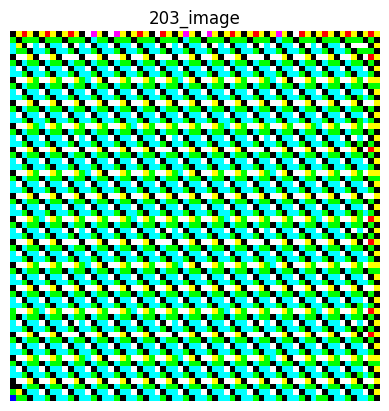

  0%|          | 0/644 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [14]:
for epoch in range(n_epochs):
    
    for ii, real_images in tqdm(enumerate(train_loader), total=len(train_loader)):
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device)
        outputR = netD(real_images)
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        outputF = netD(fake)
        # Detach outputF to avoid in-place operations on it
        outputF_detach = outputF.detach()
        errG = (torch.mean((outputR - torch.mean(outputF_detach) + labels) ** 2) +
                torch.mean((outputF - torch.mean(outputR) - labels) ** 2))/2
        errG.backward()
        goptim.step()
        if (ii+1) % (len(train_loader)//2) == 0:
            print(epoch + 1, epoch, ii+1, len(train_loader))

    show_generated_img('%s_image'%epoch)

In [15]:
gen_z = torch.randn(32, nz, 1, 1, device=device)
gen_images = (netG(gen_z).to("cpu").clone().detach() + 1)/2
gen_images = gen_images.numpy().transpose(0, 2, 3, 1)


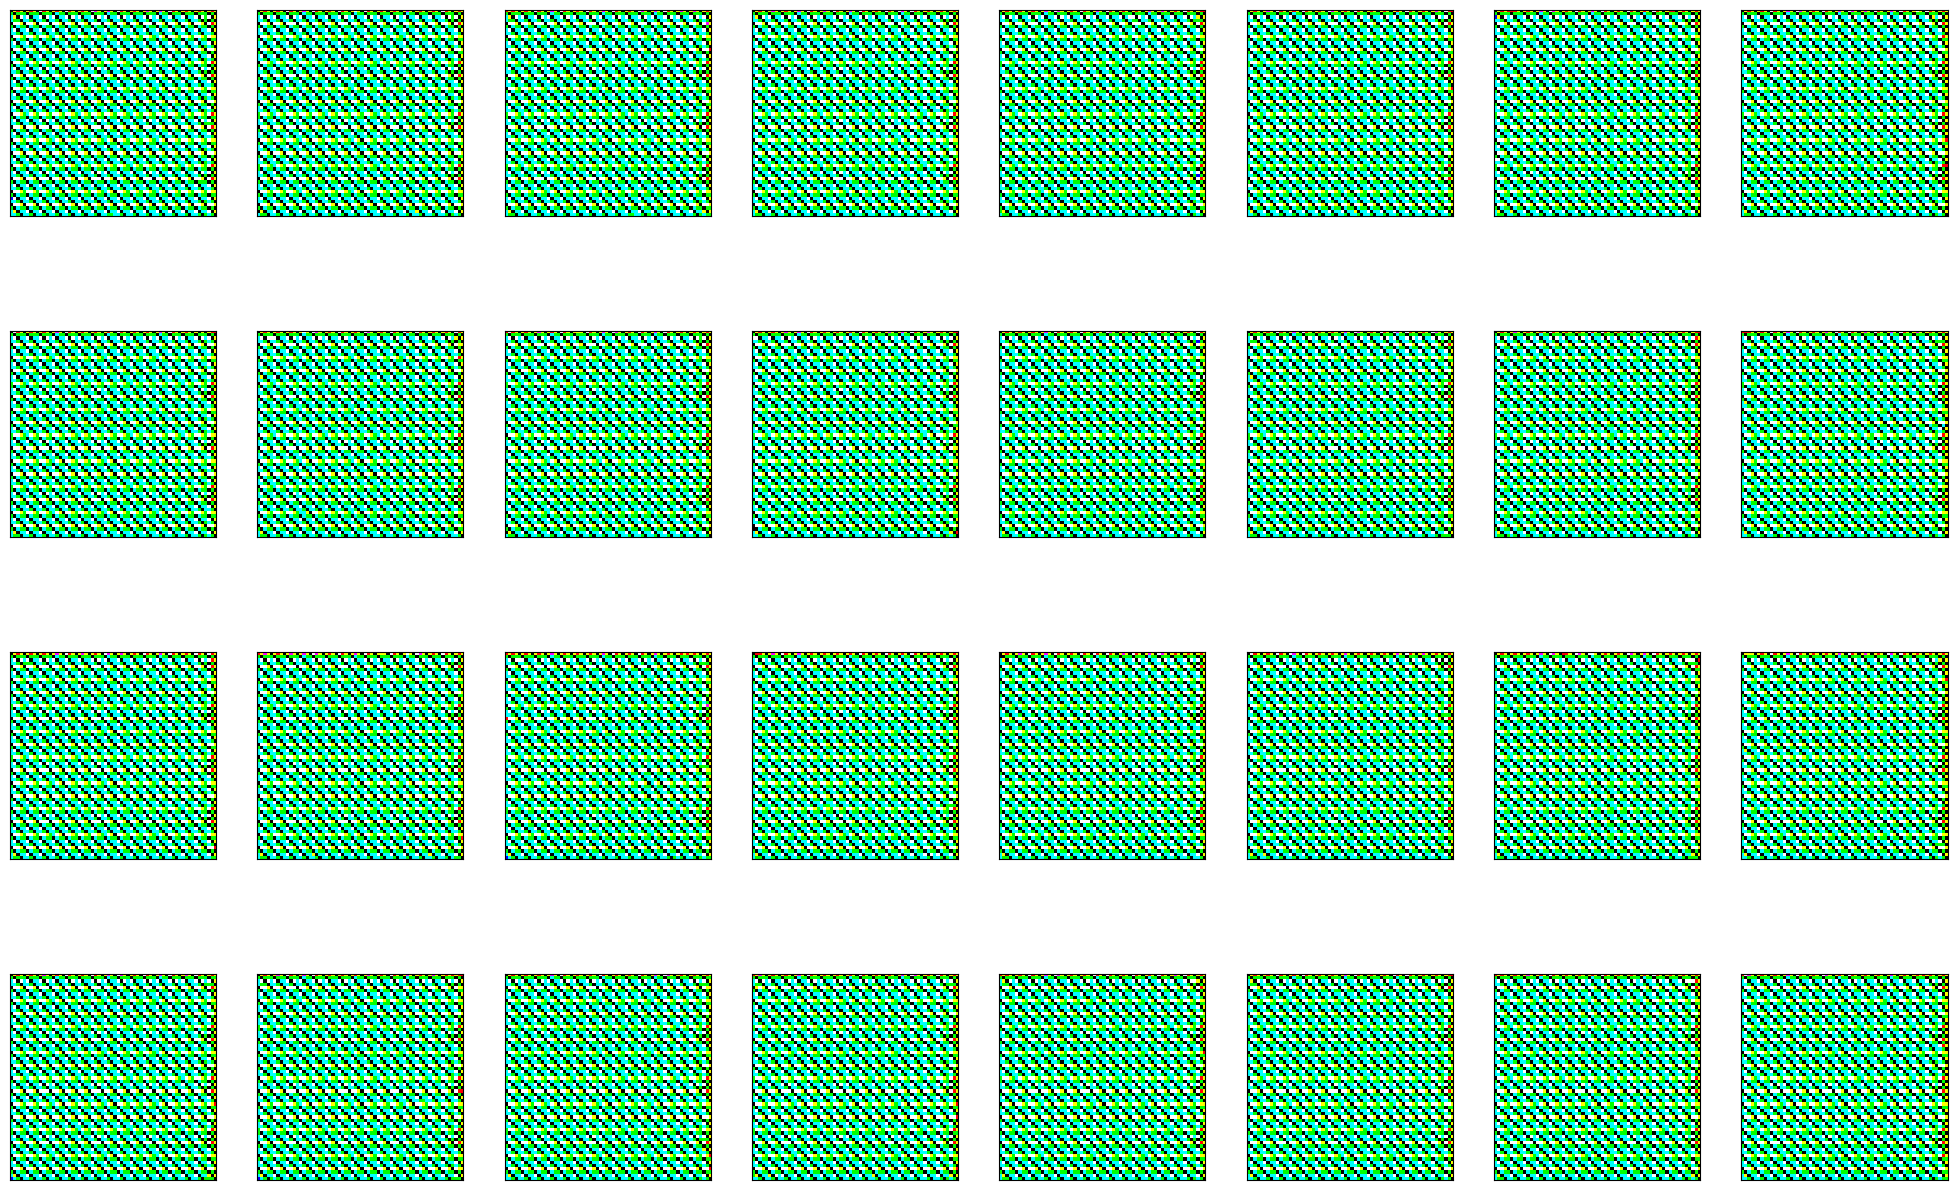

In [16]:
fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(gen_images):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow(img)


In [17]:
if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
im_batch_size = 50
n_images=100
for i_batch in range(0, n_images, im_batch_size):
    gen_z = torch.randn(im_batch_size, nz, 1, 1, device=device)
    gen_images = (netG(gen_z) + 1)/2
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))


import shutil
shutil.make_archive('images', 'zip', '../output_images')


'/kaggle/working/images.zip'